# Convolutional Neural Network for Fashion Mnist Dataset

We implement a Convolutional Neural Network for solving the multiclass image classification problem of Fashion Mnist dataset https://github.com/zalandoresearch/fashion-mnist.
We also Tune the Hyperparameters of the choosen model:
- First we investigete three diffrent architectures of CNN, we choose the one with the best validation accurraccy
- Secondly we tune the hyperparameters of the chossen Architecture CNN.

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Flatten, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

from tensorflow.keras.utils import to_categorical


from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
###### A class to calculate exceution time

from contextlib import ContextDecorator
from dataclasses import dataclass, field
import time
import datetime
from datetime import datetime


from typing import Any, Callable, ClassVar, Dict, Optional

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

@dataclass
class Timer(ContextDecorator):
    """Time your code using a class, context manager, or decorator"""

    timers: ClassVar[Dict[str, float]] = dict()
    name: Optional[str] = None
    text: str = "Elapsed time: {:0.4f} seconds"
    logger: Optional[Callable[[str], None]] = print
    _start_time: Optional[float] = field(default=None, init=False, repr=False)

    def __post_init__(self) -> None:
        """Initialization: add timer to dict of timers"""
        if self.name:
            self.timers.setdefault(self.name, 0)

    def start(self) -> None:
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self) -> float:
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        # Calculate elapsed time
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None

        # Report elapsed time
        if self.logger:
            self.logger(self.text.format(elapsed_time))
        if self.name:
            self.timers[self.name] += elapsed_time

        return elapsed_time

    def __enter__(self) -> "Timer":
        """Start a new timer as a context manager"""
        self.start()
        return self

    def __exit__(self, *exc_info: Any) -> None:
        """Stop the context manager timer"""
        self.stop()

## I- Models

### I-1 Import Data

In [4]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


### I-2 Split Data

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)

### I-3 Preprocess Data

In [7]:
nb_classes = 10 

X_train = X_train.reshape(48000, 784)
X_val = X_val.reshape(12000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_val /= 255
X_test/= 255

Y_train = to_categorical(y_train, nb_classes)
Y_val = to_categorical(y_val, nb_classes)
Y_test= to_categorical(y_test, nb_classes)

In [8]:
### reshape our inputs to CNN
img_rows = 28
img_cols = 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

## IV- CNN with Lenet Architecture

In [9]:

def model_like_lenet(input_shape, nb_classes):
    
    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=2))

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=2))

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))

    model.add(Dense(units=nb_classes, activation = 'softmax'))
    
    return model

In [10]:
model_like_lenet = model_like_lenet(input_shape, nb_classes)
model_like_lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 8)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        1168      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [11]:
model_like_lenet.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [12]:
with Timer(name="context manager"):
    history_model_like_lenet = model_like_lenet.fit(X_train, Y_train,
                                                batch_size=256,
                                                epochs=100,
                                                verbose=1,
                                                validation_data=(X_val,Y_val))

Epoch 1/100
188/188 [==============================] - 15s 7ms/step - loss: 0.7991 - accuracy: 0.7243 - val_loss: 0.5360 - val_accuracy: 0.8061
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 0.4810 - accuracy: 0.8264 - val_loss: 0.4304 - val_accuracy: 0.8453
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 0.4275 - accuracy: 0.8473 - val_loss: 0.4227 - val_accuracy: 0.8484
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 0.3990 - accuracy: 0.8581 - val_loss: 0.3659 - val_accuracy: 0.8727
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 0.3648 - accuracy: 0.8686 - val_loss: 0.3418 - val_accuracy: 0.8808
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 0.3474 - accuracy: 0.8746 - val_loss: 0.3291 - val_accuracy: 0.8839
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 0.3273 - accuracy: 0.8831 - val_loss: 0.3143 - val_accuracy: 0.891

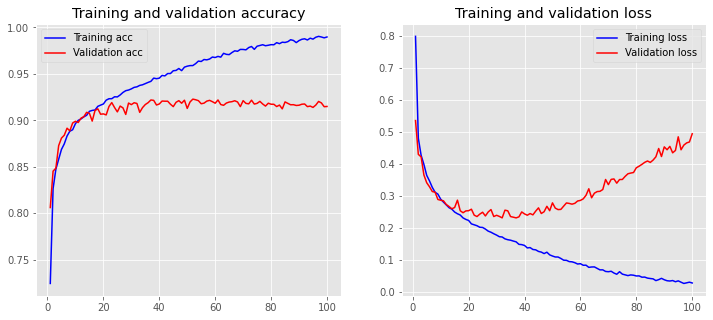

In [13]:
plot_history(history_model_like_lenet)

In [14]:
score = model_like_lenet.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model_like_lenet.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model_like_lenet.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.022722480818629265
Train accuracy: 0.9926249980926514
-------------------------------
Validation loss: 0.4947095513343811
Validation accuracy: 0.9149166941642761
-------------------------------
Test loss: 0.5769954323768616
Test accuracy: 0.9053999781608582


## IV- CNN with alexnet Architecture

In [15]:
clear_session()
def model_like_alexnet(input_shape, num_classes):
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))

  
    model.add(Dense(10, activation='softmax'))


    return model

In [16]:
model_like_alexnet = model_like_alexnet(input_shape, nb_classes)
model_like_alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [17]:
model_like_alexnet.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

Elapsed time: 0.0109 seconds


In [18]:
with Timer(name="context manager"):
    history_model_like_alexnet = model_like_alexnet.fit(X_train, Y_train,
                                                batch_size=256,
                                                epochs=100,
                                                verbose=1,
                                                validation_data=(X_val,Y_val))

Epoch 1/100
188/188 [==============================] - 3s 10ms/step - loss: 0.8631 - accuracy: 0.6955 - val_loss: 0.5539 - val_accuracy: 0.7964
Epoch 2/100
188/188 [==============================] - 1s 8ms/step - loss: 0.5374 - accuracy: 0.8033 - val_loss: 0.4838 - val_accuracy: 0.8265
Epoch 3/100
188/188 [==============================] - 2s 8ms/step - loss: 0.4620 - accuracy: 0.8322 - val_loss: 0.4263 - val_accuracy: 0.8461
Epoch 4/100
188/188 [==============================] - 1s 8ms/step - loss: 0.4256 - accuracy: 0.8452 - val_loss: 0.3922 - val_accuracy: 0.8574
Epoch 5/100
188/188 [==============================] - 1s 8ms/step - loss: 0.3926 - accuracy: 0.8576 - val_loss: 0.3812 - val_accuracy: 0.8622
Epoch 6/100
188/188 [==============================] - 2s 8ms/step - loss: 0.3703 - accuracy: 0.8651 - val_loss: 0.3653 - val_accuracy: 0.8670
Epoch 7/100
188/188 [==============================] - 1s 8ms/step - loss: 0.3513 - accuracy: 0.8717 - val_loss: 0.3403 - val_accuracy: 0.878

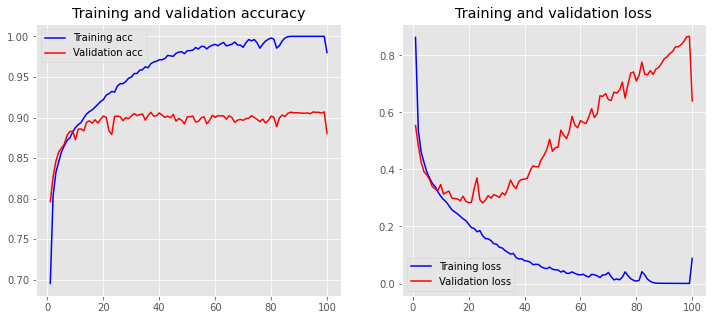

In [19]:
plot_history(history_model_like_alexnet)

In [20]:
score = model_like_alexnet.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model_like_alexnet.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model_like_alexnet.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.188217893242836
Train accuracy: 0.9402499794960022
-------------------------------
Validation loss: 0.6403799057006836
Validation accuracy: 0.8803333044052124
-------------------------------
Test loss: 0.7272402048110962
Test accuracy: 0.8683000206947327


## IV- CNN with VGG Architecture

In [21]:
clear_session()
def model_like_VGG(input_shape, nb_classes):
    
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))

    model.add(Dense(units=nb_classes, activation = 'softmax'))
    
    return model

In [22]:
model_like_VGG = model_like_VGG(input_shape, nb_classes)
model_like_VGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                    

In [23]:
model_like_VGG.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [24]:
with Timer(name="context manager"):
    history_model_like_VGG = model_like_VGG.fit(X_train, Y_train,
                                                batch_size=256,
                                                epochs=100,
                                                verbose=1,
                                                validation_data=(X_val,Y_val))

Epoch 1/100
188/188 [==============================] - 3s 11ms/step - loss: 0.6541 - accuracy: 0.7649 - val_loss: 0.4183 - val_accuracy: 0.8563
Epoch 2/100
188/188 [==============================] - 2s 9ms/step - loss: 0.3886 - accuracy: 0.8609 - val_loss: 0.3464 - val_accuracy: 0.8758
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 0.3238 - accuracy: 0.8827 - val_loss: 0.2860 - val_accuracy: 0.8999
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2890 - accuracy: 0.8933 - val_loss: 0.2747 - val_accuracy: 0.9009
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2587 - accuracy: 0.9063 - val_loss: 0.2761 - val_accuracy: 0.8993
Epoch 6/100
188/188 [==============================] - 2s 8ms/step - loss: 0.2422 - accuracy: 0.9117 - val_loss: 0.2566 - val_accuracy: 0.9052
Epoch 7/100
188/188 [==============================] - 2s 8ms/step - loss: 0.2192 - accuracy: 0.9196 - val_loss: 0.2363 - val_accuracy: 0.913

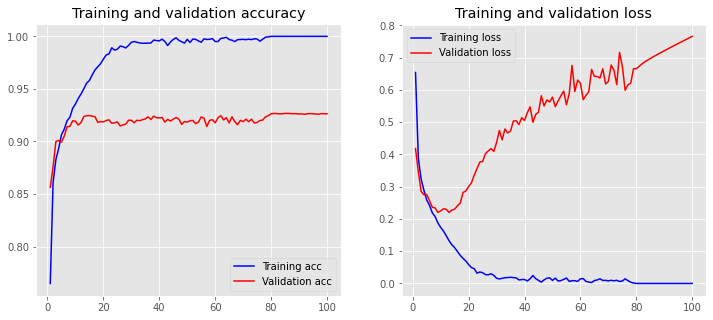

In [25]:
plot_history(history_model_like_VGG)

In [26]:
score = model_like_VGG.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = model_like_VGG.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = model_like_VGG.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 2.669541117938934e-06
Train accuracy: 1.0
-------------------------------
Validation loss: 0.7662050724029541
Validation accuracy: 0.9263333082199097
-------------------------------
Test loss: 0.9652671813964844
Test accuracy: 0.9197999835014343


The best validation accuracy is reached by a CNN with VGG structure. We also noticed that all the tested CNN overfit since there a gap betwwen train accurracy and validation accuracy.

## II- tune Hyperparemeters

In [27]:
def data():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train,    y_train, test_size=0.2, random_state=12345)
    X_train = X_train.reshape(48000, 784)
    X_val = X_val.reshape(12000, 784)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255
    nb_classes = 10
    Y_train = to_categorical(y_train, nb_classes)
    Y_val = to_categorical(y_val, nb_classes)
    
    img_rows = 28
    img_cols = 28
    input_shape = (1, img_rows, img_cols)
    X_train = X_train.reshape(X_train.shape[0],1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0],1, img_rows, img_cols)
    return X_train, Y_train, X_val, Y_val

In [28]:
def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()

    model_choice = {{choice(['one', 'two'])}}
    if model_choice == 'one':
        model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same', input_shape=(1,28,28), data_format='channels_first'))
        model.add(Conv2D(16, kernel_size=3, activation='relu',padding='same'))
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
    elif model_choice == 'two':
        model.add(Conv2D(32, kernel_size=3, activation='relu',padding='same', input_shape=(1,28,28), data_format='channels_first'))
        model.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2,strides=2))
        model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Flatten())
    model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    choiceval = {{choice(['one', 'two'])}}
    if choiceval == 'two':
        model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(10, activation='softmax'))
    
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer=Adam(learning_rate=0.001))
    model.fit(X_train, Y_train,
              batch_size=256,
              epochs=100,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Val accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [29]:

clear_session()
X_train, Y_train, X_val, Y_val = data()
with Timer(name="context manager"):
    best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='CNN_Fashion-minst_vf')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 58/100

188/188 - 2s - loss: 0.1163 - accuracy: 0.9547 - val_loss: 0.2275 - val_accuracy: 0.9268 - 2s/epoch - 12ms/step

Epoch 59/100

188/188 - 2s - loss: 0.1166 - accuracy: 0.9560 - val_loss: 0.2348 - val_accuracy: 0.9278 - 2s/epoch - 12ms/step

Epoch 60/100

188/188 - 2s - loss: 0.1173 - accuracy: 0.9560 - val_loss: 0.2408 - val_accuracy: 0.9294 - 2s/epoch - 12ms/step

Epoch 61/100

188/188 - 2s - loss: 0.1103 - accuracy: 0.9590 - val_loss: 0.2455 - val_accuracy: 0.9287 - 2s/epoch - 12ms/step

Epoch 62/100

188/188 - 2s - loss: 0.1088 - accuracy: 0.9597 - val_loss: 0.2459 - val_accuracy: 0.9279 - 2s/epoch - 12ms/step

Epoch 63/100

188/188 - 2s - loss: 0.1117 - accuracy: 0.9586 - val_loss: 0.2388 - val_accuracy: 0.9270 - 2s/epoch - 12ms/step

Epoch 64/100

188/188 - 2s - loss: 0.1096 - accuracy: 0.9590 - val_loss: 0.2441 - val_accuracy: 0.9273 - 2s/epoch - 12ms/step

Epoch 65/100

188/188 - 2s - loss

In [30]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'Dense': 0, 'Dense_1': 1, 'Dropout': 0.620928759028244, 'Dropout_1': 0.8757087615162081, 'Dropout_2': 0.41368880671027375, 'Dropout_3': 0.389249226578688, 'Dropout_4': 0.4773379816989519, 'Dropout_5': 0.563806896305963, 'model_choice': 1, 'model_choice_1': 1}


## III- Final Model

In [34]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12345)

nb_classes = 10 

X_train = X_train.reshape(48000, 784)
X_val = X_val.reshape(12000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_val /= 255
X_test/= 255

Y_train = to_categorical(y_train, nb_classes)
Y_val = to_categorical(y_val, nb_classes)
Y_test= to_categorical(y_test, nb_classes)


### reshape our inputs to CNN
img_rows = 28
img_cols = 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [36]:
clear_session()
cnn_best = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.41),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.39),

    Flatten(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.48),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.56),

    Dense(10, activation='softmax')
])
cnn_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                        

In [37]:
cnn_best.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [38]:
history_cnn_best = cnn_best.fit(X_train, Y_train,
                                batch_size=256,
                                epochs=100,
                                verbose=1,
                                callbacks=[monitor],
                                validation_data=(X_val,Y_val))

Epoch 1/100
188/188 [==============================] - 4s 15ms/step - loss: 0.9595 - accuracy: 0.6798 - val_loss: 2.4498 - val_accuracy: 0.1597
Epoch 2/100
188/188 [==============================] - 2s 13ms/step - loss: 0.5322 - accuracy: 0.8010 - val_loss: 1.2043 - val_accuracy: 0.5772
Epoch 3/100
188/188 [==============================] - 3s 16ms/step - loss: 0.4287 - accuracy: 0.8435 - val_loss: 0.3735 - val_accuracy: 0.8643
Epoch 4/100
188/188 [==============================] - 2s 13ms/step - loss: 0.3732 - accuracy: 0.8635 - val_loss: 0.2973 - val_accuracy: 0.8932
Epoch 5/100
188/188 [==============================] - 2s 13ms/step - loss: 0.3419 - accuracy: 0.8760 - val_loss: 0.2395 - val_accuracy: 0.9122
Epoch 6/100
188/188 [==============================] - 2s 13ms/step - loss: 0.3166 - accuracy: 0.8844 - val_loss: 0.2598 - val_accuracy: 0.9032
Epoch 7/100
188/188 [==============================] - 2s 13ms/step - loss: 0.2996 - accuracy: 0.8908 - val_loss: 0.2226 - val_accuracy:

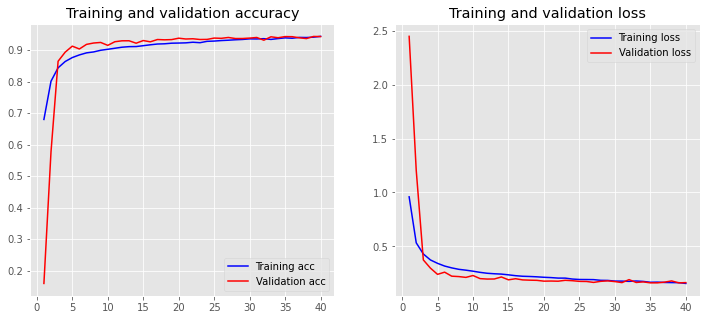

In [39]:
plot_history(history_cnn_best)

In [40]:
score = cnn_best.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.10071165859699249
Train accuracy: 0.9639583230018616
-------------------------------
Validation loss: 0.16047406196594238
Validation accuracy: 0.9424999952316284
-------------------------------
Test loss: 0.18984216451644897
Test accuracy: 0.9319000244140625


Obvsiouly, the validation accuracy is about 94%, but we suspect our model of overfitting. to fight this, we train the best model with augmented data startegy.

In [44]:
save_path = "/content/gdrive/My Drive/Deep_Learning_bb_22/CNN_Fashion-minst"
import pickle
import os

# save:
f = open(os.path.join(save_path,"history_cnn_fashion_mnist_vf.pckl"), 'wb')
pickle.dump(history_cnn_best.history, f)
f.close()

# save entire network to HDF5 (save everything, suggested)
cnn_best.save(os.path.join(save_path,"network_cnn_fashion_mnist_vf.h5"))

In [45]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=256)
val_batches = gen.flow(X_val, Y_val, batch_size=256)

In [46]:
clear_session()

In [47]:
cnn_best.fit_generator(batches, steps_per_epoch=48000//256, epochs=100,
                    validation_data=val_batches, validation_steps=12000//256,callbacks=[monitor])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


187/187 [==============================] - 23s 121ms/step - loss: 0.3748 - accuracy: 0.8643 - val_loss: 0.2818 - val_accuracy: 0.8967
Epoch 2/100
187/187 [==============================] - 25s 136ms/step - loss: 0.3286 - accuracy: 0.8790 - val_loss: 0.2578 - val_accuracy: 0.9084
Epoch 3/100
187/187 [==============================] - 29s 155ms/step - loss: 0.3155 - accuracy: 0.8842 - val_loss: 0.2423 - val_accuracy: 0.9111
Epoch 4/100
187/187 [==============================] - 21s 111ms/step - loss: 0.3054 - accuracy: 0.8876 - val_loss: 0.2319 - val_accuracy: 0.9142
Epoch 5/100
187/187 [==============================] - 22s 119ms/step - loss: 0.2984 - accuracy: 0.8898 - val_loss: 0.2366 - val_accuracy: 0.9143
Epoch 6/100
187/187 [==============================] - 22s 118ms/step - loss: 0.2961 - accuracy: 0.8913 - val_loss: 0.2332 - val_accuracy: 0.9155
Epoch 7/100
187/187 [==============================] - 21s 110ms/step - loss: 0.2907 - accuracy: 0.8942 - val_loss: 0.2333 - val_accurac

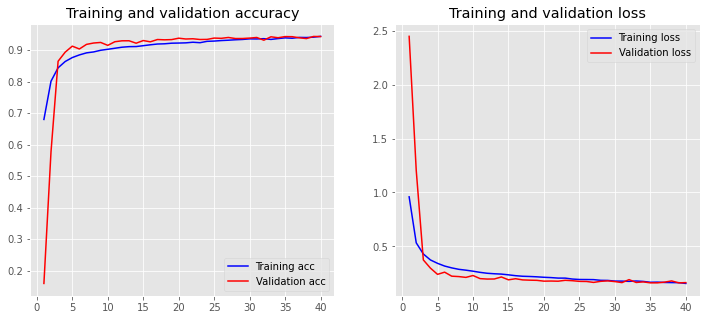

In [50]:
plot_history(history_cnn_best)

In [49]:
score = cnn_best.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = cnn_best.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.14640532433986664
Train accuracy: 0.9453125
-------------------------------
Validation loss: 0.17157545685768127
Validation accuracy: 0.937583327293396
-------------------------------
Test loss: 0.19597743451595306
Test accuracy: 0.930400013923645


we can remark, that we rduce the gap between the Train accuracy and the validation accuracy.

In [48]:
## save our final model for production and further use
save_path = "/content/gdrive/My Drive/Deep_Learning_bb_22/CNN_Fashion-minst"
import pickle
import os

# save:
f = open(os.path.join(save_path,"history_cnn_gen_fashion_mnist_vf.pckl"), 'wb')
pickle.dump(history_cnn_best.history, f)
f.close()

# save entire network to HDF5 (save everything, suggested)
cnn_best.save(os.path.join(save_path,"network_cnn_gen_fashion_mnist_vf.h5"))